# 读取数据并显示

100%|██████████| 10000/10000 [00:00<00:00, 3993434.26it/s]


5


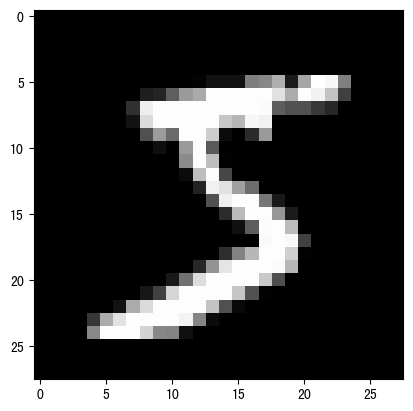

0


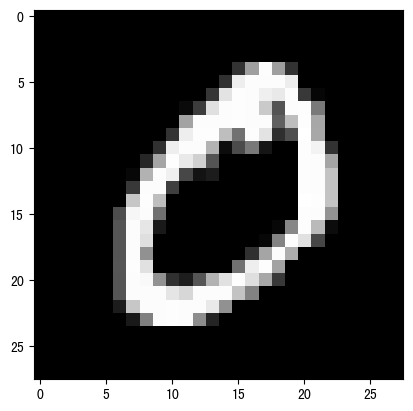

7


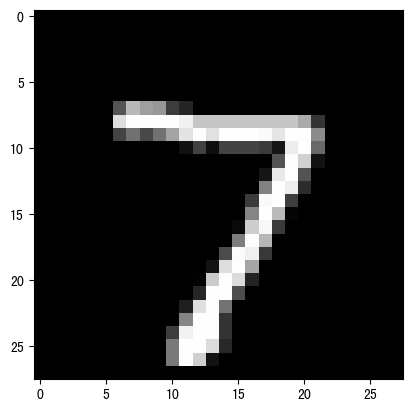

2


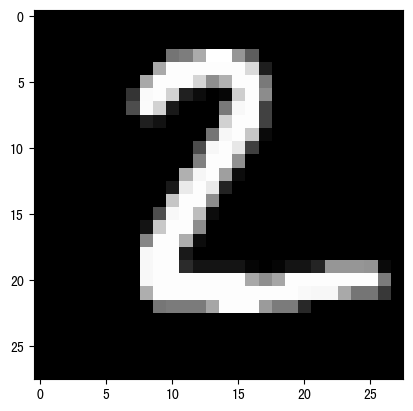

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
dataset_folder = './MNIST_data/'
files_name = {'train_images': 'train-images-idx3-ubyte',
              'train_labels': 'train-labels-idx1-ubyte',
              'test_images': 't10k-images-idx3-ubyte',
              'test_labels': 't10k-labels-idx1-ubyte'}
def read_images(filename):
    with open(filename, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')
        images = np.zeros((num_images, num_rows, num_cols))
        for i in tqdm(range(num_images)):
            for j in range(num_rows):
                for k in range(num_cols):
                    images[i][j][k] = int.from_bytes(f.read(1), 'big')
    return images
def read_labels(filename):
    with open(filename, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')
        labels = np.zeros(num_labels, dtype=int)
        for i in tqdm(range(num_labels)):
            labels[i] = int.from_bytes(f.read(1), 'big')
    return labels
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()
def show_images(images, labels):
    for i in range(len(images)):
        print(labels[i])
        show_image(images[i])
def load_data():
    train_images = read_images(dataset_folder + files_name['train_images'])
    train_labels = read_labels(dataset_folder + files_name['train_labels'])
    test_images = read_images(dataset_folder + files_name['test_images'])
    test_labels = read_labels(dataset_folder + files_name['test_labels'])
    return train_images, train_labels, test_images, test_labels
train_images, train_labels, test_images, test_labels = load_data()
show_images(train_images[:2], train_labels[:2])
show_images(test_images[:2], test_labels[:2])


# 利用numpy定义模型

In [116]:
class mynet():
    def __init__(self, hidden_nodes=128, loss_function='cross_entropy', learning_rate=0.1, lambda_=10e-3):
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.input_nodes = 28 * 28
        self.hidden_nodes = hidden_nodes
        self.output_nodes = 10
        self.w1 = np.random.randn(self.hidden_nodes, self.input_nodes)
        self.b1 = np.zeros((self.hidden_nodes, 1))
        self.w2 = np.random.randn(self.output_nodes, self.hidden_nodes)
        self.b2 = np.zeros((self.output_nodes, 1))
        self.activation = lambda x: 1 / (1 + np.exp(-x))
        if loss_function == 'cross_entropy':
            self.loss = lambda y, y_hat: -np.sum(y * np.log(y_hat))+self.lambda_/2*(np.sum(self.w1)+np.sum(self.w2))
        elif loss_function == 'mse':
            self.loss = lambda y, y_hat: np.sum((y - y_hat)**2)/2+self.lambda_/2*(np.sum(self.w1)+np.sum(self.w2))
        elif loss_function == 'hinge':
            self.loss = lambda y, y_hat: np.sum(np.maximum(0, 1 - y * y_hat))+self.lambda_/2*(np.sum(self.w1)+np.sum(self.w2))
        elif loss_function == 'logistic':
            self.loss = lambda y, y_hat: np.sum(np.log(1 + np.exp(-y * y_hat)))+self.lambda_/2*(np.sum(self.w1)+np.sum(self.w2))
        elif loss_function == 'softmax':
            self.loss = lambda y, y_hat: -np.sum(y * np.log(y_hat))+self.lambda_/2*(np.sum(self.w1)+np.sum(self.w2))
        else:
            raise ValueError('Unknown loss function')
        
    def query(self, x):
        x = x.reshape(-1, 1)
        z1 = np.dot(self.w1, x) + self.b1
        a1 = self.activation(z1)
        z2 = np.dot(self.w2, a1) + self.b2
        a2 = self.activation(z2)
        return np.argmax(a2)
    
    def train(self, x, label):
        x = x.reshape(-1, 1)
        y = np.zeros((10, 1))
        y[label] = 1
        z1 = np.dot(self.w1, x) + self.b1
        a1 = self.activation(z1)
        z2 = np.dot(self.w2, a1) + self.b2
        a2 = self.activation(z2)
        loss = self.loss(y, a2)
        dz2 = a2 - y
        dw2 = np.dot(dz2, a1.T) + self.lambda_ * self.w2
        db2 = dz2
        da1 = np.dot(self.w2.T, dz2)
        dz1 = da1 * a1 * (1 - a1)
        dw1 = np.dot(dz1, x.T) + self.lambda_ * self.w1
        db1 = dz1
        self.w1 -= self.learning_rate * dw1
        self.b1 -= self.learning_rate * db1
        self.w2 -= self.learning_rate * dw2
        self.b2 -= self.learning_rate * db2
        return loss
        
    def test(self, images, labels):
        correct = 0
        for i in range(len(images)):
            if self.query(images[i]) == labels[i]:
                correct += 1
        return correct / len(images)
    
    def train_epoch(self, images, labels):
        loss = 0
        last_accuaracy = 0
        for i in tqdm(range(len(images))):
            loss = self.train(images[i], labels[i])
            # 学习率衰减
            self.learning_rate *= 0.999
            # 正则化系数衰减
            self.lambda_ *= 0.999
            # 每500次迭代保存一次最好的模型
            if i % 500 == 0:
                # 保存准确率和loss为json文件
                with open('accuracy.json', 'a') as f:
                    f.write(str(last_accuaracy) + '\n')
                with open('loss.json', 'a') as f:
                    f.write(str(loss /60000) + '\n')
                if self.test(test_images, test_labels) > last_accuaracy:
                    last_accuaracy = self.test(test_images, test_labels)
                    self.save_model('model.npy')
            
        return loss / len(images)
    
    def save_model(self, filename):
        # save model to file
        # 按json保存权重和偏置
        model = {'w1': self.w1, 'b1': self.b1, 'w2': self.w2, 'b2': self.b2}
        np.save(filename, model)
        
    def load_model(self, filename):
        # load model from file
        model = np.load(filename, allow_pickle=True).item()
        self.w1 = model['w1']
        self.b1 = model['b1']
        self.w2 = model['w2']
        self.b2 = model['b2']
        
            

1. 初始化参数（`__init__` 方法）：
   - `hidden_nodes`：隐藏层的节点数，默认为128。
   - `loss_function`：损失函数的选择，默认为交叉熵 ('cross_entropy')。也可以选择均方误差 ('mse')、铰链损失 ('hinge')、逻辑损失 ('logistic') 或 softmax损失 ('softmax')。
   - `learning_rate`：学习率，默认为0.1，用于在梯度下降过程中更新权重。
   - `lambda_`：正则化系数，默认为0.001，用于控制过拟合，通过添加权重的平方和到损失函数中。

   网络结构参数：
   - 输入层节点数固定为784（对应于28x28像素的图像）。
   - 输出层节点数为10，通常对应于10个类别的分类任务。

   权重和偏置初始化：
   - 权重使用正态分布随机初始化。
   - 偏置初始化为0。

   激活函数设为Sigmoid函数。

2. 查询（`query` 方法）：
   - 接受输入`x`，执行前向传播，计算隐藏层和输出层的激活值，最后返回输出层激活值最高的索引作为预测类别。

3. 训练（`train` 方法）：
   - 采用标准的前向传播和反向传播算法。
   - 前向传播计算每层的输出。
   - 反向传播通过计算损失函数相对于权重的梯度来更新权重和偏置。

4. 测试（`test` 方法）：
   - 对一批图像进行分类，计算模型的分类准确率。

5. 训练一个周期（`train_epoch` 方法）：
   - 对整个数据集进行一次完整的训练，包括多次迭代更新权重。
   - 实现学习率和正则化系数的衰减，以提高训练过程中的模型性能。
   - 每500次迭代保存一次最好模型和性能指标（准确率和损失）。

6. 保存和加载模型（`save_model` 和 `load_model` 方法）：
   - 允许将训练好的模型权重和偏置保存到文件，并在需要时加载。


# 训练模型

In [117]:
from tqdm import tqdm
hidden_nodes = 128
loss_function = 'cross_entropy'
learning_rate = 0.1
lambda_ = 10e-3

model = mynet(hidden_nodes, loss_function, learning_rate, lambda_)

train_datas = train_images/255.0*0.99+0.01
test_datas = test_images/255.0*0.99+0.01
# 清空文件
with open('accuracy.json', 'w') as f:
    f.write('')
with open('loss.json', 'w') as f:
    f.write('')


1. 导入必要的库：
   - 使用 `tqdm` 来添加进度条，以便在训练大量数据时观察进度。

2. 模型初始化：
   - 设置网络参数：隐藏层节点数为128，损失函数为交叉熵（'cross_entropy'），学习率为0.1，正则化系数为0.01（`10e-3`）。
   - 创建 `mynet` 类的实例 `model`，传入上述参数进行初始化。

3. 数据预处理：
   - 将训练和测试数据 (`train_images` 和 `test_images`) 标准化，即将像素值缩放到0.01到1之间。这通常有助于模型更好地学习，避免数值计算问题。

4. 清空记录文件：
   - 打开 `accuracy.json` 和 `loss.json` 文件，并以写入模式 ('w') 打开，写入空字符串，这样做是为了开始新的训练前清除之前的记录。


In [118]:
model.train_epoch(train_datas, train_labels)

  0%|          | 0/60000 [00:00<?, ?it/s]/var/folders/h7/mrvl5vl94tndlzjrl0l6930w0000gn/T/ipykernel_84882/1015682651.py:12: RuntimeWarning: overflow encountered in exp
  self.activation = lambda x: 1 / (1 + np.exp(-x))
100%|██████████| 60000/60000 [01:12<00:00, 829.11it/s] 


0.8396

In [114]:
# show_images(test_datas[:1], test_labels[:1])
# print(train_datas[0])
res = model.query(test_datas[0])
print(res)
print(test_labels[0])

7
7


# 分析

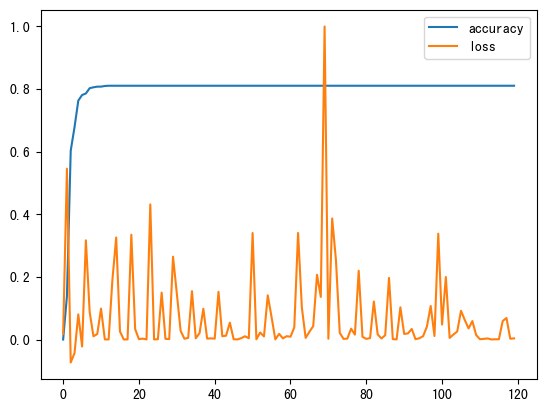

In [119]:
# 将准确率和loss绘制成图
import matplotlib.pyplot as plt
import json
with open('accuracy.json', 'r') as f:
    accuracy = [float(x) for x in f.readlines()]
with open('loss.json', 'r') as f:
    loss = [float(x) for x in f.readlines()]
    loss = [x/max(loss) for x in loss]
plt.plot(accuracy)
plt.plot(loss)
plt.legend(['accuracy', 'loss'])
plt.show()


In [120]:
model.test(test_datas, test_labels)

0.8396

### 总结和后续步骤

1. **性能分析**：
   - 准确率接近84%，表明大多数测试数据都被正确分类。这说明模型的结构和学习算法都比较适合这类问题。

2. **模型结构**：
   - 模型采用了Sigmoid激活函数和交叉熵损失函数，这通常适合二分类问题。但对于多类分类任务（如手写数字识别），使用ReLU激活函数和Softmax输出层可能会更有效。

3. **调参优化**：
   - 考虑调整学习率和正则化系数的初始值及其衰减策略。学习率如果设置得过高或过低都可能影响训练效果。正则化系数的适当选择可以帮助模型更好地泛化。
   - 尝试更多的隐藏层或不同数量的节点，可能会进一步提高模型的性能。

4. **数据处理**：
   - 尽管已经进行了标准化处理，进一步的数据增强（如旋转、缩放、裁剪）可能会帮助模型抵抗过拟合，增强模型的泛化能力。

5. **进一步实验**：
   - 考虑实现早停（Early Stopping）等技术，以避免训练过程中的过拟合。
   - 试验不同的批量大小，以找到最适合当前数据和网络结构的配置。

6. **记录和监控**：
   - 继续监控模型在训练过程中的表现，特别是损失和准确率的变化，以便及时调整训练策略。


项目地址：https://github.com/Decision9/neural-work/tree/main/code